In [1]:
import numpy as np
import pandas as pd
import torch

from scipy.spatial.distance import cdist

from dist_ae import SetAutoencoderGNN, train_dist_ae
from losses import sliced_wasserstein_distance, mmd, sinkhorn
from plot_utils import plot_latent_pairs_overlaid

from distns import distns

distn_name = 'normal'
generate_params = distns[distn_name]['generate_params']
sample_distn = distns[distn_name]['sample']
fr_dist = distns[distn_name]['fr_dist']


In [2]:
# generate multivariate normal data
n_sets = 1000
set_size = 100
n_features = 5

params_train = generate_params(n_sets, n_features)
params_test = generate_params(n_sets, n_features)

x_train = sample_distn(*params_train, n_sets, set_size, n_features)
x_test = sample_distn(*params_test, n_sets, set_size, n_features)


In [3]:
dist_ae = SetAutoencoderGNN(n_features, 16, 64, set_size)
optimizer = torch.optim.Adam(dist_ae.parameters(), lr=5e-4)

# create dataloader
train_loader = torch.utils.data.DataLoader(torch.from_numpy(x_train).float(), batch_size=20, shuffle=True)

def loss_fn(X, Y):
    return torch.vmap(sliced_wasserstein_distance, randomness='different')(X, Y).mean()

dist_ae = train_dist_ae(dist_ae, optimizer, train_loader, loss_fn, n_epochs = 50)

Epoch 0, Loss: 0.946084201335907
Epoch 10, Loss: 0.8119845390319824
Epoch 20, Loss: 0.5762737393379211
Epoch 30, Loss: 0.6340317726135254
Epoch 40, Loss: 0.4205376207828522


In [3]:
dist_ae = SetAutoencoderGNN(n_features, 16, 64, set_size)
optimizer = torch.optim.Adam(dist_ae.parameters(), lr=5e-4)

# create dataloader
train_loader = torch.utils.data.DataLoader(torch.from_numpy(x_train).float(), batch_size=20, shuffle=True)

def loss_fn(X, Y):
    return torch.vmap(mmd, randomness='different')(X, Y).mean()

dist_ae = train_dist_ae(dist_ae, optimizer, train_loader, loss_fn, n_epochs = 50)

Epoch 0, Loss: 0.613516092300415
Epoch 10, Loss: 0.2380482703447342
Epoch 20, Loss: 0.20946407318115234
Epoch 30, Loss: 0.10016562789678574
Epoch 40, Loss: 0.10789956152439117


In [3]:
dist_ae = SetAutoencoderGNN(n_features, 16, 64, set_size)
optimizer = torch.optim.Adam(dist_ae.parameters(), lr=5e-4)

# create dataloader
train_loader = torch.utils.data.DataLoader(torch.from_numpy(x_train).float(), batch_size=20, shuffle=True)

def loss_fn(X, Y):
    return torch.vmap(sinkhorn, randomness='different')(X, Y).mean()

dist_ae = train_dist_ae(dist_ae, optimizer, train_loader, loss_fn, n_epochs = 50)

Epoch 0, Loss: 6.854394435882568
Epoch 10, Loss: 5.534419536590576
Epoch 20, Loss: 5.553267478942871
Epoch 30, Loss: 3.9213051795959473
Epoch 40, Loss: 4.127709865570068


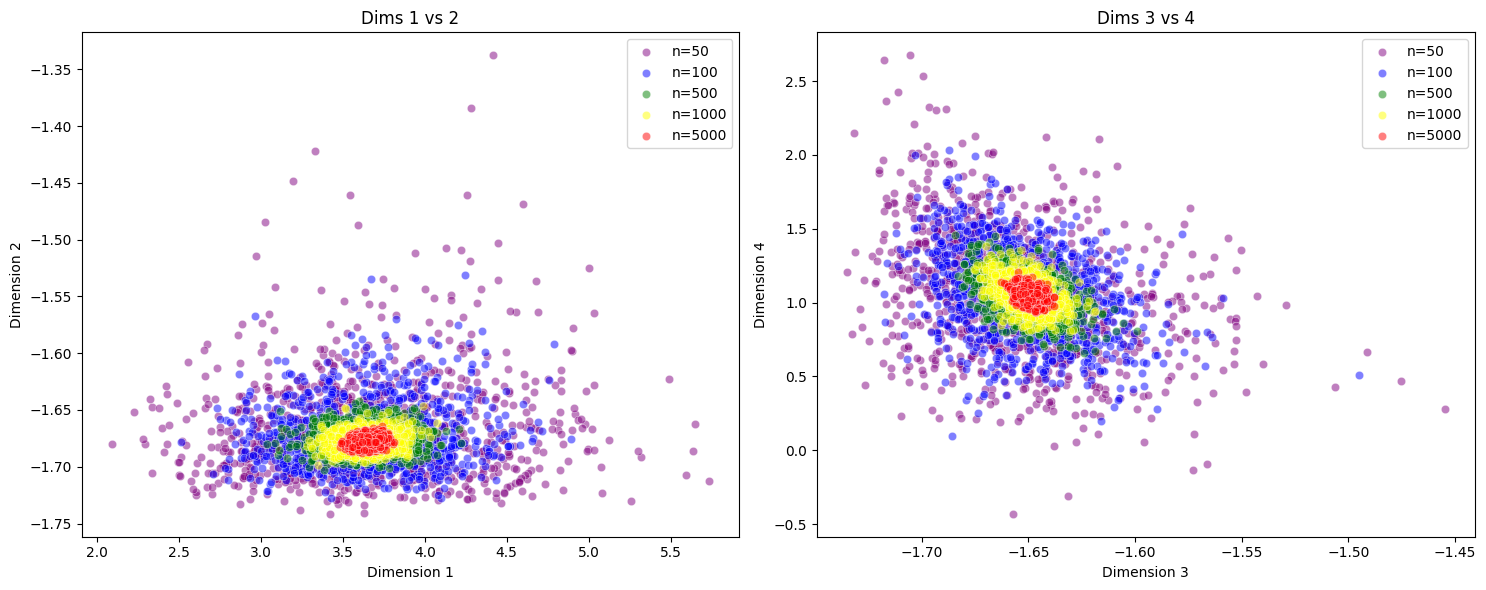

In [4]:
# Generate a single set of parameters
params = generate_params(1, n_features)

def sample_distn_fixed_params(n_sets, set_size):
    return sample_distn(*params, n_sets, set_size, n_features)

plot_latent_pairs_overlaid(dist_ae, sample_distn_fixed_params)

In [9]:
num_sets = 100
num_points_per_set = 10_000
params = generate_params(num_sets, n_features)
# sample 500 sets of 10,000 points from the distribution
x_samp = sample_distn(*params, num_sets, num_points_per_set, n_features)
z_samp, x_samp_recon = dist_ae(torch.from_numpy(x_samp).float())
z_samp = z_samp.detach().numpy()

# Compute pairwise cosine distances
lat_dists = cdist(z_samp, z_samp, metric='euclidean')


In [7]:
# compute distances between parameters
fr_dists = fr_dist(params)
l2_dists = np.linalg.norm(params[0][:, None, :] - params[0][None, :, :], axis=2)

In [8]:
dist_corr = np.corrcoef(np.vstack([l2_dists.flatten(), fr_dists.flatten(), lat_dists.flatten()]))
df = pd.DataFrame(dist_corr, index=['l2', 'fr', 'lat'], columns=['l2', 'fr', 'lat'])
print(df)

           l2        fr       lat
l2   1.000000  0.224558  0.953118
fr   0.224558  1.000000  0.257801
lat  0.953118  0.257801  1.000000
